In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/pdf_parsing

/content/drive/MyDrive/pdf_parsing


In [ ]:
!pip install layoutparser

In [ ]:
!pip install "layoutparser[effdet]"

In [ ]:
!pip install layoutparser torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

In [ ]:
!pip install "layoutparser[paddledetection]"

In [ ]:
!pip install "layoutparser[ocr]"

In [ ]:
!pip install google-cloud-vision==1.0.2

In [9]:
import cv2

# 이미지 불러오기
image = cv2.imread("./eng_paper_report.jpg")
image = image[..., ::-1]

# Image Segmentation을 위한 모델 Detectron2 적용

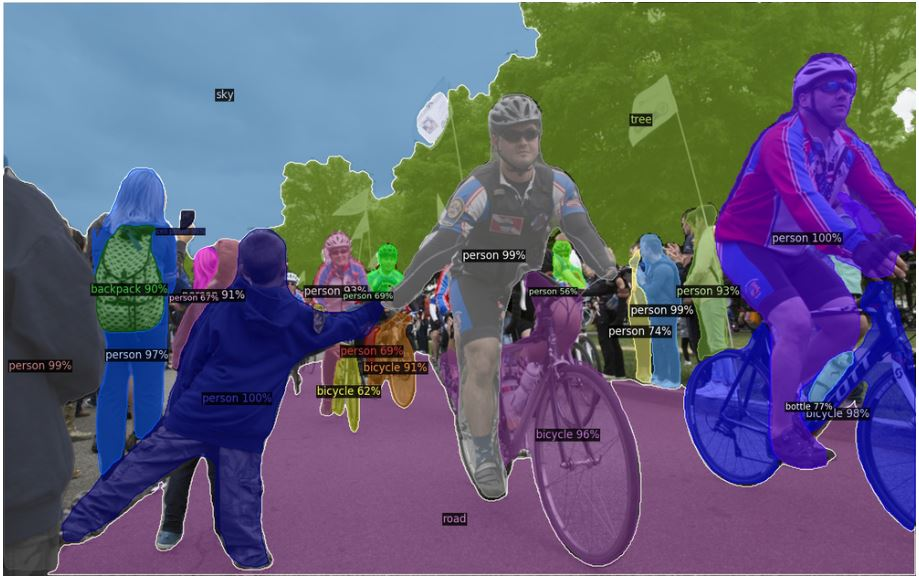

In [10]:
import layoutparser as lp

# Model 생성
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map = {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
# Layout 감지
layout = model.detect(image)

config.yaml?dl=1: 8.19kB [00:02, 2.87kB/s]
model_final.pth?dl=1: 856MB [00:59, 14.3MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


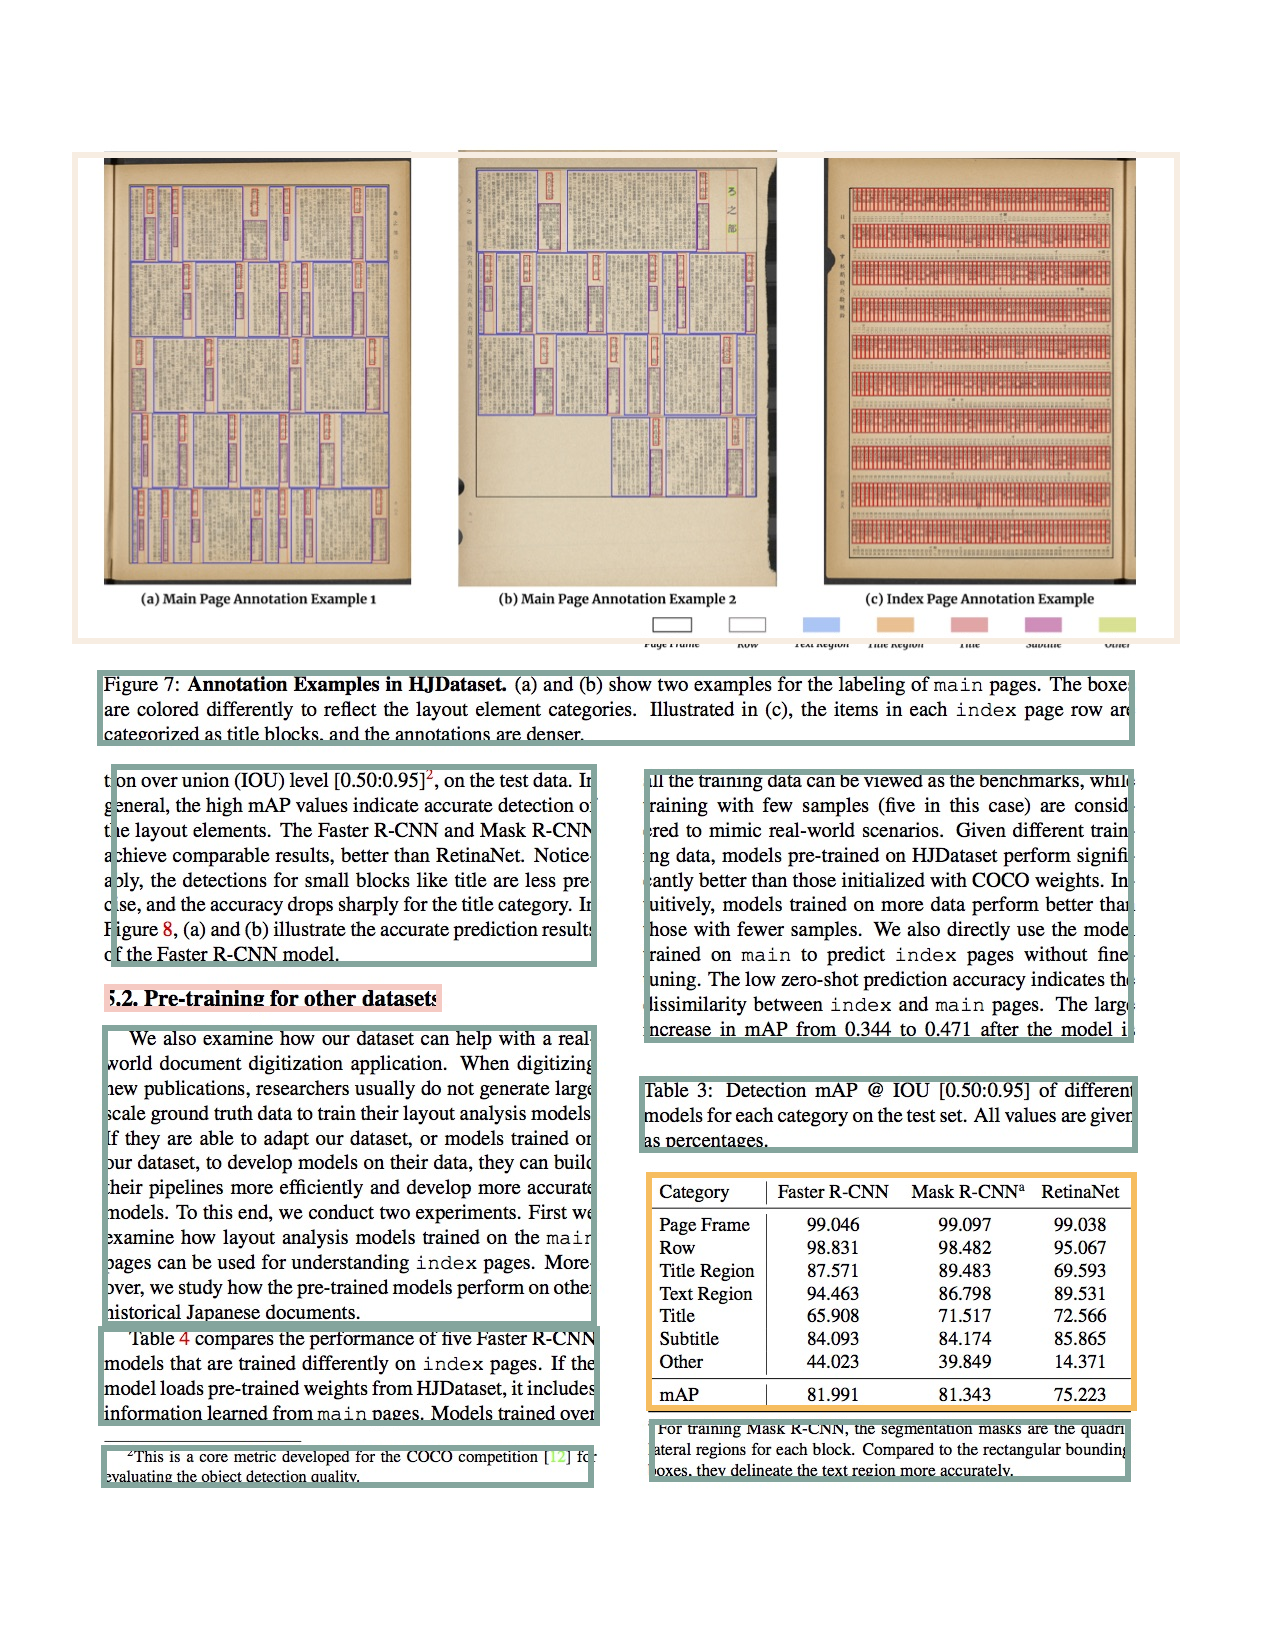

In [11]:
# Image 내 Layout 시각화
lp.draw_box(image, layout)

In [12]:
# 각 Label의 Layout Block 정의
text_blocks = lp.Layout([b for b in layout if b.type=="Text"])
title_block = lp.Layout([b for b in layout if b.type=="Title"])
list_blocks = lp.Layout([b for b in layout if b.type=='List'])
table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [13]:
# Figure 내 Text 제거
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [14]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

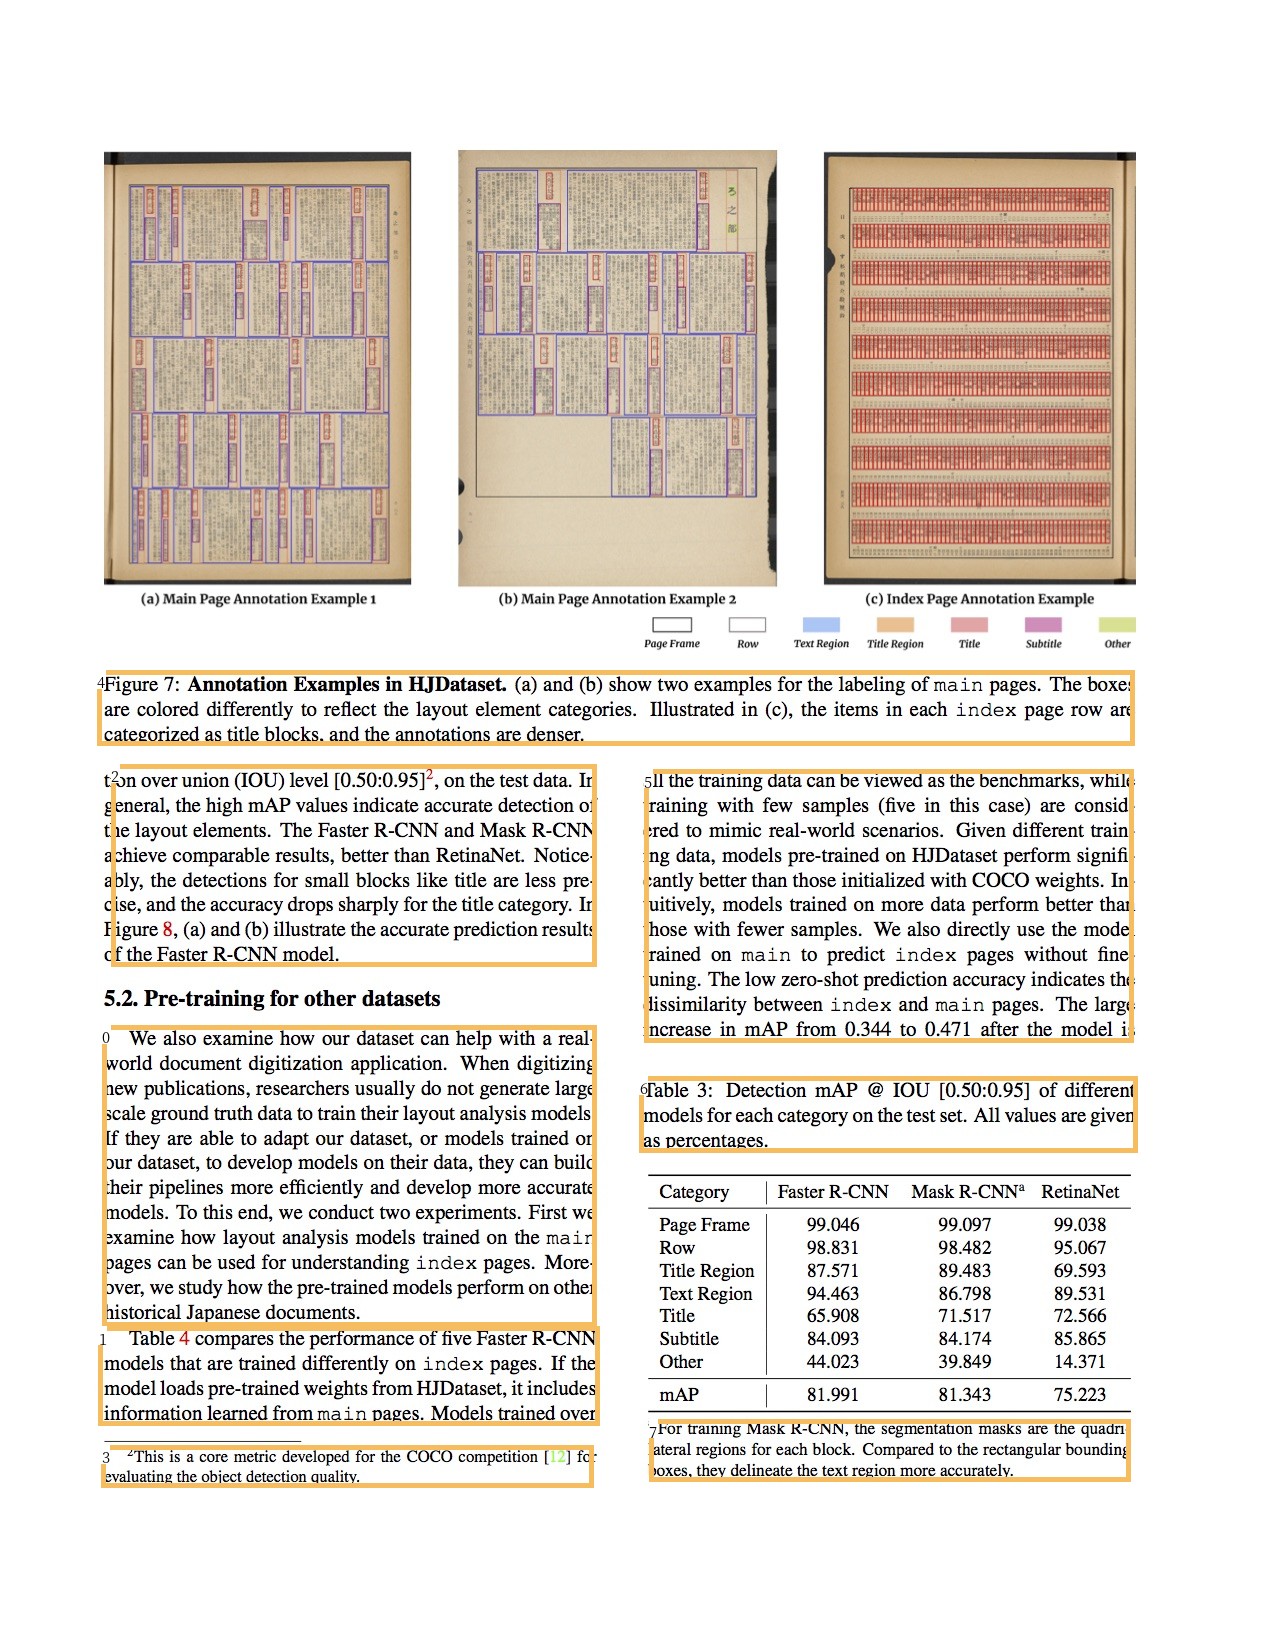

In [15]:
lp.draw_box(image,
            text_blocks,
            box_width = 5,
            show_element_id = True)

# 각 Layout 내 Text 추출을 위해 Tesseact-ocr 기술 사용

In [16]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,036 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [17]:
# 번역 언어 = English
ocr_agent = lp.TesseractAgent(languages='eng')

In [18]:
# Box 내 Padding 정보 추가하여 글자 짤림 방지
for block in text_blocks:
    segment_image = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(image))


    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [19]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

We also examine how our dataset can help with a real-
world document digitization application. When digitizing
new publications, researchers usually do not generate large
scale ground truth data to train their layout analysis models.
If they are able to adapt our dataset, or models trained on
our dataset, to develop models on their data, they can build
their pipelines more efficiently and develop more accurate
models. To this end, we conduct two experiments. First we
examine how layout analysis models trained on the main
pages can be used for understanding index pages. More-
over, we study how the pre-trained models perform on other
historical Japanese documents.

---
Table 4 compares the performance of five Faster R-CNN
models that are trained differently on index pages. If the
model loads pre-trained weights from HJDataset, it includes
information learned from main pages. Models trained over

---
tion over union (IOU) level [0.50:0.95]’, on the test data. In
general, the high mAP v

In [20]:
sentence = ["".join(txt) for txt in text_blocks.get_texts()]

In [21]:
print(sentence)

['We also examine how our dataset can help with a real-\nworld document digitization application. When digitizing\nnew publications, researchers usually do not generate large\nscale ground truth data to train their layout analysis models.\nIf they are able to adapt our dataset, or models trained on\nour dataset, to develop models on their data, they can build\ntheir pipelines more efficiently and develop more accurate\nmodels. To this end, we conduct two experiments. First we\nexamine how layout analysis models trained on the main\npages can be used for understanding index pages. More-\nover, we study how the pre-trained models perform on other\nhistorical Japanese documents.\n\x0c', 'Table 4 compares the performance of five Faster R-CNN\nmodels that are trained differently on index pages. If the\nmodel loads pre-trained weights from HJDataset, it includes\ninformation learned from main pages. Models trained over\n\x0c', 'tion over union (IOU) level [0.50:0.95]’, on the test data. In\n